# Weekly S&P 500 Direction Classification with XGBoost

This script implements an end-to-end machine learning pipeline to **predict the weekly direction** (up/down) of the S&P 500 index using an XGBoost classifier.

**Key steps:**
1. **Data Acquisition:** fetch daily S&P 500 OHLCV via `yfinance` (with retry/backoff) and resample to weekly bars.  
2. **Feature Engineering:** compute technical and macro indicators (RSI, EMA crossover, ATR, VWAP deviation, volume spikes, yield spread, 20-week trend strength).  
3. **Model Training:** split into training and hold-out (last 52 weeks or 20%), fit an `XGBClassifier`, and tune hyperparameters via time-series cross-validation.  
4. **Evaluation:** report precision, recall, F1-score, and accuracy on the hold-out, and visualize actual vs. predicted up/down signals.  
5. **Interpretation:** extract and plot feature importances to identify the most influential indicators.


In [2]:
# 1) Download daily data & resample to weekly bars (Friday close)
daily = (
    yf.Ticker("^GSPC")
      .history(period="max")[['Open','High','Low','Close','Volume']]
)
weekly = (
    daily.resample('W-FRI').agg({
        'Open':   'first',
        'High':   'max',
        'Low':    'min',
        'Close':  'last',
        'Volume': 'sum'
    })
    .iloc[:-1]  # drop last partial week
    .copy()
)

# 2) Create binary target: did this week's close beat next week's?
weekly['Tomorrow'] = weekly['Close'].shift(-1)
weekly['Target']   = (weekly['Tomorrow'] > weekly['Close']).astype(int)
weekly.drop(columns=['Tomorrow'], inplace=True)

## Feature Engineering

In this cell we compute all of our weekly technical and macro features:

- **RSI (14-week):** measures recent momentum  
- **EMA crossover (50 vs 200-week):** trend-following signal  
- **ATR (14-week):** average true range for volatility  
- **VWAP deviation:** price vs volume-weighted average price  
- **Volume spike (4-week avg):** unusually high trading volume  
- **Yield spread (10yr – 5yr):** interest-rate differential  
- **Trend strength (20-week up-count):** how many of the last 20 weeks were up  

In [3]:
# RSI (14-week)
delta    = weekly['Close'].diff()
gain     = delta.clip(lower=0)
loss     = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
weekly['RSI_14'] = 100 - (100 / (1 + avg_gain/avg_loss))

# EMA crossover (50 vs 200 weeks)
weekly['EMA_50']   = weekly['Close'].ewm(span=50,  adjust=False).mean()
weekly['EMA_200']  = weekly['Close'].ewm(span=200, adjust=False).mean()
weekly['MA_Cross'] = (weekly['EMA_50'] > weekly['EMA_200']).astype(int)

# ATR (14 weeks)
hl = weekly['High'] - weekly['Low']
hp = (weekly['High'] - weekly['Close'].shift()).abs()
lp = (weekly['Low']  - weekly['Close'].shift()).abs()
tr = pd.concat([hl, hp, lp], axis=1).max(axis=1)
weekly['ATR_14'] = tr.rolling(14).mean()

# VWAP deviation
vwap = (weekly['Close'] * weekly['Volume']).cumsum() / weekly['Volume'].cumsum()
weekly['VWAP_dev'] = weekly['Close'] / vwap

# Volume spike (4-week average)
weekly['Vol_Avg_4'] = weekly['Volume'].rolling(4).mean()
weekly['Vol_Spike']  = weekly['Volume'] / weekly['Vol_Avg_4']

# Yield spread (10yr – 5yr)
tnx = yf.Ticker("^TNX").history(period="max")["Close"]
fvx = yf.Ticker("^FVX").history(period="max")["Close"]
tnx = tnx.reindex(weekly.index, method="ffill")
fvx = fvx.reindex(weekly.index, method="ffill")
weekly['Yield_Spread'] = (tnx - fvx) / 10

# Trend strength (20-week up-count)
weekly['Trend_20'] = weekly['Target'].shift(1).rolling(20).sum()

In [31]:
# 1) Drop any rows missing our new features
feature_cols = [
    'RSI_14','MA_Cross','ATR_14','VWAP_dev',
    'Vol_Spike','Yield_Spread','Trend_20'
]
weekly.dropna(subset=feature_cols, inplace=True)

# 2) Hold-out: last 52 weeks or 20% of data, whichever is smaller
n = len(weekly)
test_size = min(int(n * 0.2), 52)
train, test = weekly.iloc[:-test_size], weekly.iloc[-test_size:]

X_train, y_train = train[feature_cols], train['Target']
X_test,  y_test  = test [feature_cols],  test ['Target']

xgb = XGBClassifier(
    n_estimators=5000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=1
)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print("Weekly hold-out precision (XGBoost):", precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Weekly hold-out precision (XGBoost): 0.6818181818181818
              precision    recall  f1-score   support

           0       0.57      0.71      0.63        24
           1       0.68      0.54      0.60        28

    accuracy                           0.62        52
   macro avg       0.62      0.62      0.61        52
weighted avg       0.63      0.62      0.61        52



Feature importances (highest→lowest):
MA_Cross        0.189218
Trend_20        0.141015
ATR_14          0.139905
RSI_14          0.136130
VWAP_dev        0.134314
Vol_Spike       0.130828
Yield_Spread    0.128590
dtype: float32


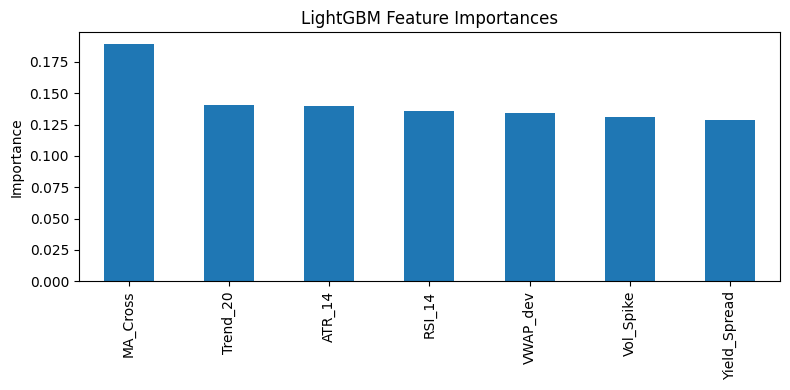

In [32]:
importances = pd.Series(xgb.feature_importances_, index=feature_cols)
importances = importances.sort_values(ascending=False)

print("Feature importances (highest→lowest):")
print(importances)

# Visualize
importances.plot(kind='bar', figsize=(8,4))
plt.title("LightGBM Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

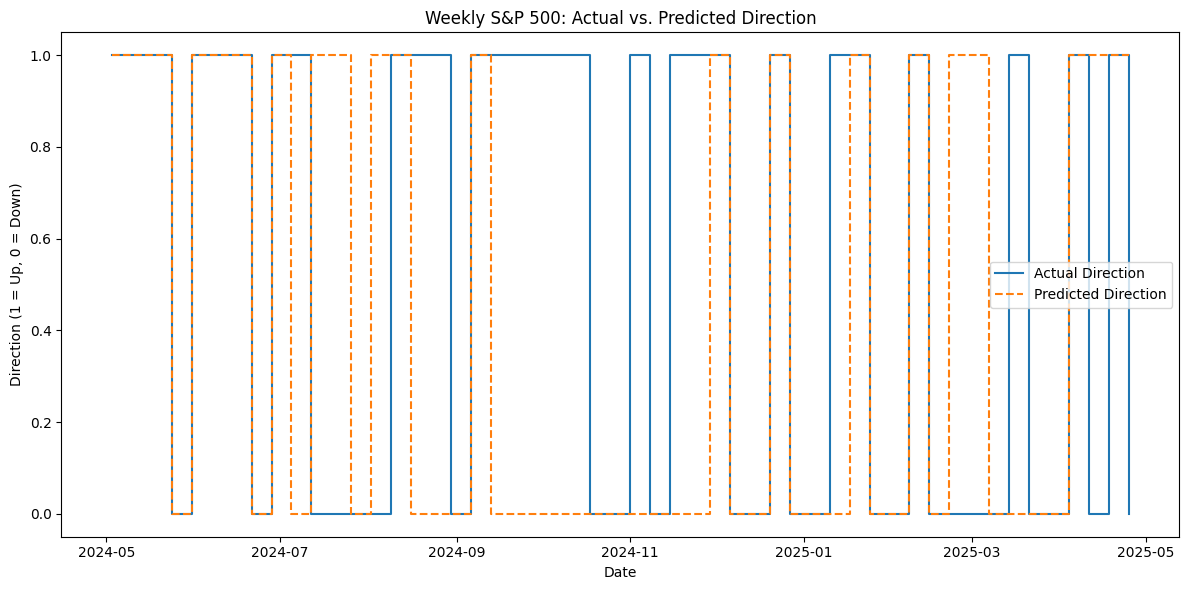

In [33]:
import matplotlib.pyplot as plt

# Assuming you still have `test`, `y_test`, and `y_pred` in your namespace:
plt.figure(figsize=(12, 6))

# Plot actual up/down (0 or 1)
plt.step(test.index, y_test, where='post', label='Actual Direction')

# Plot model predictions
plt.step(test.index, y_pred, where='post', linestyle='--', label='Predicted Direction')

plt.title('Weekly S&P 500: Actual vs. Predicted Direction')
plt.xlabel('Date')
plt.ylabel('Direction (1 = Up, 0 = Down)')
plt.legend()
plt.tight_layout()
plt.show()